In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
def plot_and_save(df, name, kind='line', xlabel=None, ylabel=None, **kwargs):
    ax = df.plot(kind=kind, **kwargs)
    
    if xlabel != None:
        ax.set_xlabel(xlabel)
    if ylabel != None:
        ax.set_ylabel(ylabel)
    
    ax.legend().set_visible(False)
    mpl.pyplot.savefig("../../dist-thrill-cluster/plots/" + name + "_no_legend.png", dpi=300)
    ax.legend().set_visible(True)
    mpl.pyplot.savefig("../../dist-thrill-cluster/plots/" + name + ".png", dpi=300)
    
    df.to_csv("../../dist-thrill-cluster/plots/" + name + ".csv")

In [3]:
data = {}

for path in glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/strong_scaling/*.json")) + glob.glob(os.path.expanduser("/amd.home/home/i11/zeitz/ma/data/results/paper/strong_scaling_less/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [4]:
dlslm_label = 'Distr. Modularity'
dlslm_me_label = 'Distr. MapEq'
seq_postfix = ' w. Seq.'
dlslm_ws_label = dlslm_label + seq_postfix

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })

In [6]:
frames['algorithm_run']['runtime'] = (frames['algorithm_run']['done_ts'] - frames['algorithm_run']['start_ts']) / 1000000.0
distributed_algo_runs = frames['algorithm_run'][pd.isnull(frames['algorithm_run'].distributed_algorithm_run_id)]
for algo in distributed_algo_runs['algorithm'].unique():
    for thread_count in frames['program_run']['workers_per_host'].unique():
        df = frames['algorithm_run'] \
            .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
            .loc[lambda x: x.algorithm == algo] \
            .loc[lambda x: x.workers_per_host == thread_count]
        base = df.loc[lambda x: x.hosts == 1]['runtime'].mean()
            
        frames['algorithm_run'].loc[df.index, 'efficiency'] = base / df['runtime'] / df['hosts']
distributed_algo_runs = frames['algorithm_run'][pd.isnull(frames['algorithm_run'].distributed_algorithm_run_id)]

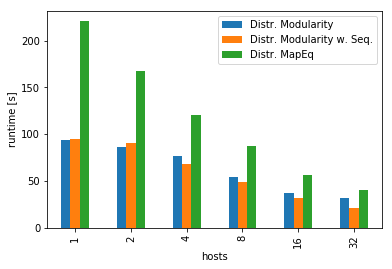

In [7]:
df = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.workers_per_host == 16] \
    .groupby(['hosts', 'algorithm'])['runtime'].mean().to_frame() \
    .unstack()["runtime"][[dlslm_label, dlslm_ws_label, dlslm_me_label]]

plot_and_save(df, "strong_scaling_16threads_runtime", kind='bar', ylabel="runtime [s]")

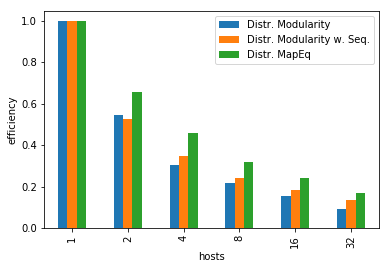

In [8]:
df = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.workers_per_host == 16] \
    .groupby(['hosts', 'algorithm'])['efficiency'].mean().to_frame() \
    .unstack()["efficiency"][[dlslm_label, dlslm_ws_label, dlslm_me_label]]

plot_and_save(df, "strong_scaling_16threads_efficiency", kind='bar', ylabel="efficiency")

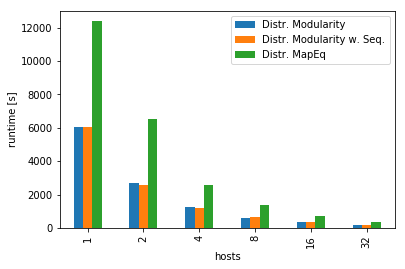

In [9]:
df = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.workers_per_host == 1] \
    .groupby(['hosts', 'algorithm'])['runtime'].mean().to_frame() \
    .unstack()["runtime"][[dlslm_label, dlslm_ws_label, dlslm_me_label]]

plot_and_save(df, "strong_scaling_1thread_runtime", kind='bar', ylabel="runtime [s]")

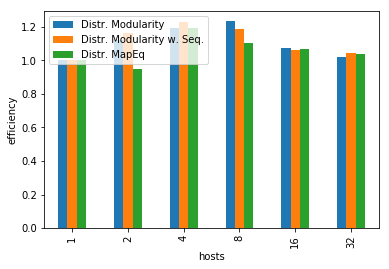

In [10]:
df = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .loc[lambda x: x.workers_per_host == 1] \
    .groupby(['hosts', 'algorithm'])['efficiency'].mean().to_frame() \
    .unstack()["efficiency"][[dlslm_label, dlslm_ws_label, dlslm_me_label]]

plot_and_save(df, "strong_scaling_1thread_efficiency", kind='bar', ylabel="efficiency")